In [2]:
import cv2
import os
import numpy as np
import math

In [93]:
def load_images_from_folder(folder):
    image_name = []
    for raw_filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, raw_filename))
        if img is not None:
            filename = raw_filename.split("_")
            print(filename)
            image_name.append(raw_filename[:-4])
    return image_name

In [94]:
def left_and_right_divider_midpoint(img):
    histogram = np.sum(img[img.shape[0]//4:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print("left base:", leftx_base, "\n", "rightx_base:", rightx_base)
    return histogram, midpoint, quarter_point, leftx_base, rightx_base

def lane_base(img, ratio_horizon_line=0.3, nsection=8):
    pos_horizon_line = 1 - ratio_horizon_line
    section = [int(img.shape[1]*(k/nsection)) for k in range(1, nsection+1)]
    histogram = np.sum(img[int(img.shape[0]*pos_horizon_line):,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base, rightx_base = section[1], section[4]
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint+quarter_point:]) + midpoint + quarter_point
    return histogram, midpoint, quarter_point, leftx_base, rightx_base

def region_of_interest(img, ratio=0.5):
    height, width = img.shape
    mask = np.zeros_like(img)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * ratio),
        (width, height * ratio),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_image = cv2.bitwise_and(img, mask)
    return cropped_image

def sliding_window_1st_deg(img, deg=1, nwindow=10):
    histogram, midpoint, quarter_point, leftx_base, rightx_base = lane_base(img)

    window_height = int(img.shape[0]/nwindow)

    # Get all the x and y positions of nonzero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the window +/- margin
    margin = 80

    # Set minimum number of pixels found for recenter window
    minpix = 5

    left_lane_inds = []
    right_lane_inds = []

    rectangle_data = []

    for n in range(nwindow):
        # Identify window boundaries
        window_top = img.shape[0] - (n+1)*window_height
        window_bot = img.shape[0] - (n)*window_height
        window_xleft_low = leftx_current - margin
        window_xleft_high = leftx_current + margin
        window_xright_low = rightx_current - margin
        window_xright_high = rightx_current + margin

        rectangle_data.append((window_top, window_bot, window_xleft_low, window_xleft_high, window_xright_low, window_xright_high))

        # Identify the nonzero pixels in window
        one_left_inds = ((nonzeroy >= window_top) & (nonzeroy < window_bot) & (nonzerox >= window_xleft_low) & (nonzerox < window_xleft_high)).nonzero()[0]
        one_right_inds = ((nonzeroy >= window_top) & (nonzeroy < window_bot) & (nonzerox >= window_xright_low) & (nonzerox < window_xright_high)).nonzero()[0]

        left_lane_inds.append(one_left_inds)
        right_lane_inds.append(one_right_inds)
        
        # Determine whether recenter or not
        if len(one_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[one_left_inds]))
        if len(one_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[one_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, deg)
    else:
        left_fit = np.array([0, 0])
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, deg)
    else:
        right_fit = np.array([0, img.shape[1]])
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

def sliding_1st_deg_inspection(img, left_fit, right_fit):
    # sliding window inspection
    left_fit_x_int = left_fit[0]*h + left_fit[1]
    right_fit_x_int = right_fit[0]*h + right_fit[1]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    rectangles = visualization_data[0]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty + left_fit[1]
    right_fitx = right_fit[0]*ploty + right_fit[1]
    for rect in rectangles:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    return out_img, left_fitx, right_fitx, ploty

def point_to_point(left_fitx, right_fitx):
    start_point = [w/2, h]
    point_avg = (left_fitx + right_fitx) / 2
    if (abs(left_fit[1] - right_fit[1]) < 10) or (left_fit[0] == 0) or (right_fit[0] == 0):
        offset_x  = (w/2) - point_avg[int(h-1)]
        end_point = [int(point_avg[int(h/2)] + offset_x), int(h/2)]
    else:
        end_point = [int(point_avg[int(h/2)]), int(h/2)]
    angle = round(math.degrees(math.atan2(end_point[1], end_point[0]-w/2)))
    return start_point, end_point, angle

In [95]:
def lane_angle(image):
    IMAGE_SIZE = (640, 480)
    w, h = IMAGE_SIZE
    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([0, 0, 0])
    upper = np.array([180, 255, 80])
    mask_image = cv2.inRange(hsv_image, lower, upper)
    kernel = np.ones((3, 3), np.uint8)
    opening_image = cv2.morphologyEx(mask_image, cv2.MORPH_OPEN, kernel)
    cropped_image = region_of_interest(opening_image)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_1st_deg(cropped_image)
    window_image, left_fitx, right_fitx, ploty = sliding_1st_deg_inspection(cropped_image, left_fit, right_fit)
    _, _, angle = point_to_point(left_fitx, right_fitx)
    return angle

In [96]:
raw_path = "F:/Neural_Network_Steering_Control/source_code/lane_helper/capture"
labeled_path = "F:/Neural_Network_Steering_Control/source_code/lane_helper/labeled"

IMAGE_SIZE = (640, 480)
w, h = IMAGE_SIZE

In [97]:
# for filename in os.listdir(raw_path):
#     image = cv2.imread(os.path.join(raw_path, filename))
#     if image is not None:
#         img = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
#         hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         lower = np.array([0, 0, 0])
#         upper = np.array([180, 255, 80])
#         mask_image = cv2.inRange(hsv_image, lower, upper)
#         kernel = np.ones((3, 3), np.uint8)
#         opening_image = cv2.morphologyEx(mask_image, cv2.MORPH_OPEN, kernel)
#         cropped_image = region_of_interest(opening_image)
#         left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_1st_deg(cropped_image)
#         window_image, left_fitx, right_fitx, ploty = sliding_1st_deg_inspection(cropped_image, left_fit, right_fit)
#         _, _, angle = point_to_point(left_fitx, right_fitx)
#         labeled = labeled_path + "/" + filename[:-4] + "_" + str(angle) + ".png"
#         cv2.imwrite(labeled, image)

In [98]:
# from error_meas import error_meas

# meas = error_meas()

# for filename in os.listdir(raw_path):
#     image = cv2.imread(os.path.join(raw_path, filename))
#     if image is not None:
#         angle, _ = meas.implement(image)
#         labeled = labeled_path + "/" + filename[:-4] + "_" + str(angle) + ".png"
#         cv2.imwrite(labeled, image)

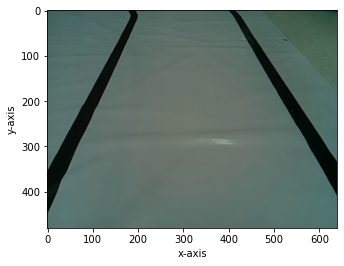

In [4]:
import matplotlib.pyplot as plt
from error_meas import error_meas

meas = error_meas()
image_path = r"labeled\train_set\20210406_23135005_90.png"
image = meas.imread(image_path)
angle, error_pos = meas.implement(image)

sample = "1"
save_dir = r"F:\Neural_Network_Steering_Control\document\images"
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
# plt.axis('off')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig(f"{save_dir}/{sample}_in_axis.png", bbox_inches='tight',pad_inches = 0)

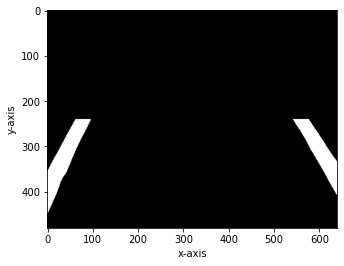

In [5]:
plt.imshow(meas.cropped_image, cmap='gray')
# plt.axis('off')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig(f"{save_dir}/{sample}_pre_axis.png", bbox_inches='tight', pad_inches = 0)

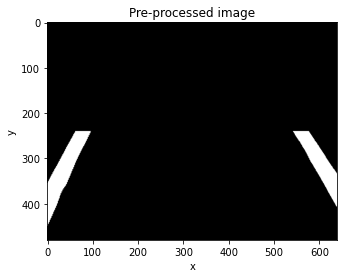

In [119]:
plt.imshow(meas.cropped_image, cmap='gray')
plt.title("Pre-processed image")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"{save_dir}/{sample}_pre_.png", bbox_inches='tight',pad_inches = 0)

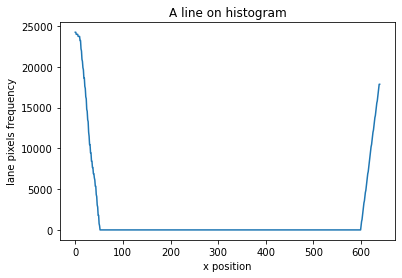

In [8]:
plt.plot(meas.histogram)
# plt.title("A line on histogram")
plt.xlabel("x position")
plt.ylabel("lane pixels frequency")
plt.savefig(f"{save_dir}/{sample}_hist_.png",pad_inches = 0)

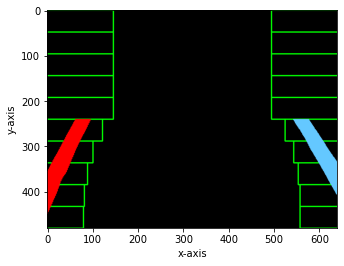

In [7]:
plt.imshow(meas.window_image)
# plt.axis('off')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig(f"{save_dir}/{sample}_mark_axis.png", bbox_inches='tight',pad_inches = 0)

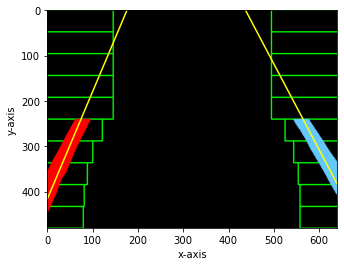

In [9]:
meas.inspect_no_angle()
# plt.axis('off')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig(f"{save_dir}/{sample}_fit_axis.png", bbox_inches='tight',pad_inches = 0)

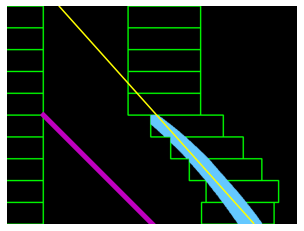

In [103]:
meas.inspect()
plt.axis('off')
# plt.savefig(f"{save_dir}/{sample}_meas.png", bbox_inches='tight',pad_inches = 0)

In [104]:
print(angle)

135
